In [1]:
import json
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split
from ast import literal_eval
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from bs4 import BeautifulSoup
import string

In [2]:
stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at",
             "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do",
             "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having",
             "he", "hed", "hes", "her", "here", "heres", "hers", "herself", "him", "himself", "his", "how",
             "hows", "i", "id", "ill", "im", "ive", "if", "in", "into", "is", "it", "its", "itself",
             "lets", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought",
             "our", "ours", "ourselves", "out", "over", "own", "same", "she", "shed", "shell", "shes", "should",
             "so", "some", "such", "than", "that", "thats", "the", "their", "theirs", "them", "themselves", "then",
             "there", "theres", "these", "they", "theyd", "theyll", "theyre", "theyve", "this", "those", "through",
             "to", "too", "under", "until", "up", "very", "was", "we", "wed", "well", "were", "weve", "were",
             "what", "whats", "when", "whens", "where", "wheres", "which", "while", "who", "whos", "whom", "why",
             "whys", "with", "would", "you", "youd", "youll", "youre", "youve", "your", "yours", "yourself",
             "yourselves"]

table = str.maketrans('', '', string.punctuation)

In [3]:
arxiv_data = pd.read_csv(
    "../../datasets/recommenders/arxiv_data/arxiv_data.csv"
)
arxiv_data.head()

,titles,summaries,terms
0,Survey on Semantic Stereo Matching / Semantic ...,Stereo matching is one of the widely used tech...,"['cs.CV', 'cs.LG']"
1,FUTURE-AI: Guiding Principles and Consensus Re...,The recent advancements in artificial intellig...,"['cs.CV', 'cs.AI', 'cs.LG']"
2,Enforcing Mutual Consistency of Hard Regions f...,"In this paper, we proposed a novel mutual cons...","['cs.CV', 'cs.AI']"
3,Parameter Decoupling Strategy for Semi-supervi...,Consistency training has proven to be an advan...,['cs.CV']
4,Background-Foreground Segmentation for Interio...,"To ensure safety in automated driving, the cor...","['cs.CV', 'cs.LG']"


In [4]:
#shuffle datasets
arxiv_data = arxiv_data.sample(frac=1)
arxiv_data.head()

,titles,summaries,terms
38953,Certainty Driven Consistency Loss on Multi-Tea...,One of the successful approaches in semi-super...,['cs.CV']
30775,End-to-end Video-level Representation Learning...,From the frame/clip-level feature learning to ...,['cs.CV']
39496,Hierarchical Attention-based Age Estimation an...,In this work we propose a novel deep-learning ...,['cs.CV']
13809,A Showcase of the Use of Autoencoders in Featu...,Autoencoders are techniques for data represent...,['cs.LG']
26260,Instance Segmentation by Deep Coloring,"We propose a new and, arguably, a very simple ...",['cs.CV']


In [5]:
# Filtering the rare terms.
arxiv_data = arxiv_data[~arxiv_data["titles"].duplicated()]
arxiv_data_filtered = arxiv_data.groupby("terms").filter(lambda x: len(x) > 1)
arxiv_data_filtered.shape

(36652, 3)

In [6]:
arxiv_data_filtered["terms"] = arxiv_data_filtered["terms"].apply(
    lambda x: literal_eval(x)
)
arxiv_data_filtered["terms"].values[:5]

array([list(['cs.CV']), list(['cs.CV']), list(['cs.CV']), list(['cs.LG']),
       list(['cs.CV'])], dtype=object)

In [7]:
test_split = 0.1

# Initial train and test split.
train_df, test_df = train_test_split(
    arxiv_data_filtered,
    test_size=test_split,
    stratify=arxiv_data_filtered["terms"].values,
)

# Splitting the test set further into validation
# and new test sets.
val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

print(f"Number of rows in training set: {len(train_df)}")
print(f"Number of rows in validation set: {len(val_df)}")
print(f"Number of rows in test set: {len(test_df)}")

Number of rows in training set: 32986
Number of rows in validation set: 1833
Number of rows in test set: 1833


In [8]:
terms = tf.ragged.constant(arxiv_data_filtered["terms"].values)
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot")
lookup.adapt(terms)
vocab = lookup.get_vocabulary()


def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)


print("Vocabulary:\n")
print(vocab)

Vocabulary:

['[UNK]', 'cs.CV', 'cs.LG', 'stat.ML', 'cs.AI', 'eess.IV', 'cs.RO', 'cs.CL', 'cs.NE', 'cs.CR', 'math.OC', 'eess.SP', 'cs.GR', 'cs.SI', 'cs.MM', 'cs.SY', 'cs.IR', 'cs.MA', 'eess.SY', 'cs.HC', 'math.IT', 'cs.IT', 'cs.DC', 'cs.CY', 'stat.AP', 'stat.TH', 'math.ST', 'stat.ME', 'eess.AS', 'q-bio.QM', 'cs.SD', 'q-bio.NC', 'cs.DS', 'cs.GT', 'cs.NI', 'cs.CG', 'cs.SE', 'I.2.6', 'stat.CO', 'math.NA', 'cs.NA', 'physics.chem-ph', 'cs.DB', 'cs.LO', 'q-bio.BM', 'cs.PL', '68T45', 'math.PR', 'cond-mat.dis-nn', 'physics.comp-ph', 'cs.CE', 'cs.AR', 'I.2.10', 'q-fin.ST', '68T05', 'math.DS', 'cond-mat.stat-mech', 'quant-ph', 'physics.data-an', 'cs.CC', 'I.4.6', 'physics.soc-ph', 'physics.ao-ph', 'econ.EM', 'cs.DM', 'q-bio.GN', 'astro-ph.IM', 'physics.med-ph', 'cs.PF', 'I.4.8', 'math.AT', 'cs.FL', 'I.4', 'q-fin.TR', 'I.5.4', 'I.2', '68U10', 'physics.optics', 'physics.geo-ph', 'hep-ex', 'cond-mat.mtrl-sci', '68T10', 'physics.flu-dyn', 'I.4; I.5', 'I.4.9', 'I.2.6; I.2.8', '68T01', '65D19', 'q-fin

In [9]:
# termsList = ["[UNK]", "A", "B", "C" , "D", "a", "b", "c", "d"]

# lookupManual = tf.keras.layers.StringLookup(output_mode="multi_hot")
# lookupManual.adapt(termsList)
# vocabManual = lookupManual.get_vocabulary()

# print("Vocabulary:\n")
# print(vocabManual)

In [10]:
# export keys to list
with open('../../saved_model/recommender/arxiv/v1/tokenizer_key.json', 'w') as file:    
    json.dump(vocab, file)

In [ ]:
train_sentences = [] 
train_labels = []
for index, item in train_df.iterrows():
    sentence = item['summaries'].lower()
    sentence = sentence.replace(",", " , ")
    sentence = sentence.replace(".", " . ")
    sentence = sentence.replace("-", " - ")
    sentence = sentence.replace("/", " / ")
    soup = BeautifulSoup(sentence)
    sentence = soup.get_text()
    words = sentence.split()
    filtered_sentence = ""
    for word in words:
        word = word.translate(table)
        if word not in stopwords:
            filtered_sentence = filtered_sentence + word + " "
    train_sentences.append(filtered_sentence)
#     label = tf.ragged.constant(item["terms"])
    label_binarized = lookup(item["terms"])
    train_labels.append(label_binarized)

In [13]:
print(train_labels[:5])

[<tf.Tensor: shape=(153,), dtype=float32, numpy=
array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)>, <tf.Tensor: shape=(153,), dtype=float32, numpy=
array([0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [14]:
val_sentences = [] 
val_labels = []
for index, item in val_df.iterrows():
    sentence = item['summaries'].lower()
    sentence = sentence.replace(",", " , ")
    sentence = sentence.replace(".", " . ")
    sentence = sentence.replace("-", " - ")
    sentence = sentence.replace("/", " / ")
    soup = BeautifulSoup(sentence)
    sentence = soup.get_text()
    words = sentence.split()
    filtered_sentence = ""
    for word in words:
        word = word.translate(table)
        if word not in stopwords:
            filtered_sentence = filtered_sentence + word + " "
    val_sentences.append(filtered_sentence)
#     label = tf.ragged.constant(item["terms"])
    label_binarized = lookup(item["terms"])
    val_labels.append(label_binarized)

In [15]:
test_sentences = [] 
test_labels = []
for index, item in test_df.iterrows():
    sentence = item['summaries'].lower()
    sentence = sentence.replace(",", " , ")
    sentence = sentence.replace(".", " . ")
    sentence = sentence.replace("-", " - ")
    sentence = sentence.replace("/", " / ")
    soup = BeautifulSoup(sentence)
    sentence = soup.get_text()
    words = sentence.split()
    filtered_sentence = ""
    for word in words:
        word = word.translate(table)
        if word not in stopwords:
            filtered_sentence = filtered_sentence + word + " "
    test_sentences.append(filtered_sentence)
#     label = tf.ragged.constant(item["terms"])
    label_binarized = lookup(item["terms"])
    test_labels.append(label_binarized)

In [16]:
train_df["summaries"].apply(lambda x: len(x.split(" "))).describe()

count    32986.000000
mean       156.472685
std         41.498940
min          5.000000
25%        128.000000
50%        154.000000
75%        183.000000
max        462.000000
Name: summaries, dtype: float64

In [17]:
vocabulary = set()
train_df["summaries"].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

153286


In [18]:
vocab_size = vocabulary_size
oov_tok = 0
padding_type='post'
trunc_type='post'
max_seqlen = 157
batch_size = 128
padding_token = "<pad>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(train_sentences)
# for tflite
#training_sequences = [list(map(float, x)) for x in training_sequences]
# end for tflite
training_padded = pad_sequences(training_sequences, maxlen=max_seqlen, padding=padding_type, truncating=trunc_type)

val_sequences = tokenizer.texts_to_sequences(val_sentences)
val_padded = pad_sequences(val_sequences, maxlen=max_seqlen, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(test_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_seqlen, padding=padding_type, truncating=trunc_type)

In [19]:
# Create the vocabulary dictionary.
# Note that the word_index attribute includes ALL words the tokenizer saw
# when fitting, even though vocab size was limited.
vocab = {}
for word, index in tokenizer.word_index.items():
    if index <= vocab_size:
        vocab[word] = index
        
# Write the vocab dictionary to a json file for loading in javascript
with open('../../saved_model/recommender/arxiv/v1/tokenizer_dictionary.json', 'w') as file:    
    json.dump(vocab, file)

In [20]:
training_padded = np.array(training_padded)
training_labels = np.array(train_labels)
val_padded = np.array(val_padded)
val_labels = np.array(val_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(test_labels)

print(training_padded.shape)
print(training_labels.shape)

(32986, 157)
(32986, 153)


In [21]:
print(training_labels)

[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


In [19]:
model = keras.Sequential()
model.add(layers.Input(shape=(max_seqlen,), dtype=tf.int32, name="input_layer"))
model.add(layers.Embedding(vocabulary_size, 25))
model.add(layers.Dropout(0.3))
model.add(layers.Conv1D(128, 5, padding='same', activation=None))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Conv1D(128, 5, padding='same', activation=None))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Conv1D(128, 5, padding='same', activation=None))
model.add(layers.BatchNormalization())
model.add(layers.Conv1D(128, 5, padding='same', activation=None))
model.add(layers.BatchNormalization())
model.add(layers.Bidirectional(tf.keras.layers.LSTM(max_seqlen, return_sequences=True, dropout=0.2)))
model.add(layers.Bidirectional(tf.keras.layers.LSTM(max_seqlen, dropout=0.2)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(lookup.vocabulary_size(), activation='sigmoid'))

model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["binary_accuracy"]
)

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 157, 25)           3832125   
                                                                 
 dropout (Dropout)           (None, 157, 25)           0         
                                                                 
 conv1d (Conv1D)             (None, 157, 128)          16128     
                                                                 
 batch_normalization (BatchN  (None, 157, 128)         512       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 157, 128)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 157, 128)          82048     
                                                        

In [21]:
custom_early_stopping = EarlyStopping(
    patience=4, 
    verbose=1
)

In [22]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,   
    patience=2, 
    min_lr=0.000001,
    verbose=1,
    cooldown=1
)

In [23]:
epochs = 200
history = model.fit(
    training_padded, 
    training_labels,
    validation_data=(val_padded, val_labels),
    callbacks=[custom_early_stopping, reduce_lr],
    epochs=epochs
)

Epoch 1/200
1031/1031 [==============================] - 84s 69ms/step - loss: 0.0315 - binary_accuracy: 0.9887 - val_loss: 0.0198 - val_binary_accuracy: 0.9941 - lr: 0.0010
Epoch 2/200
1031/1031 [==============================] - 69s 67ms/step - loss: 0.0206 - binary_accuracy: 0.9940 - val_loss: 0.0201 - val_binary_accuracy: 0.9940 - lr: 0.0010
Epoch 3/200
1031/1031 [==============================] - 68s 66ms/step - loss: 0.0200 - binary_accuracy: 0.9942 - val_loss: 0.0195 - val_binary_accuracy: 0.9941 - lr: 0.0010
Epoch 4/200
1031/1031 [==============================] - 68s 66ms/step - loss: 0.0195 - binary_accuracy: 0.9943 - val_loss: 0.0192 - val_binary_accuracy: 0.9942 - lr: 0.0010
Epoch 5/200
1031/1031 [==============================] - 68s 66ms/step - loss: 0.0190 - binary_accuracy: 0.9945 - val_loss: 0.0192 - val_binary_accuracy: 0.9942 - lr: 0.0010
Epoch 6/200
1031/1031 [==============================] - ETA: 0s - loss: 0.0186 - binary_accuracy: 0.9945
Epoch 6: ReduceLROnPlate

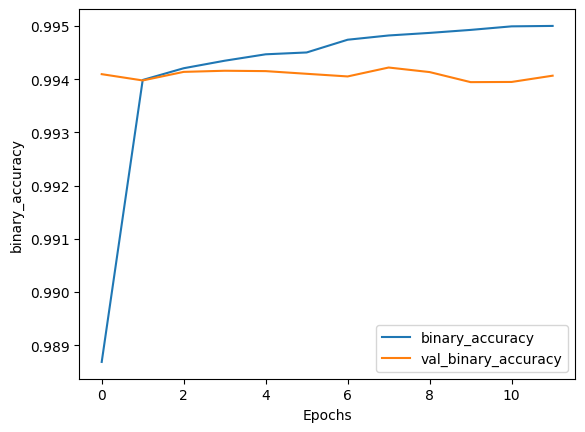

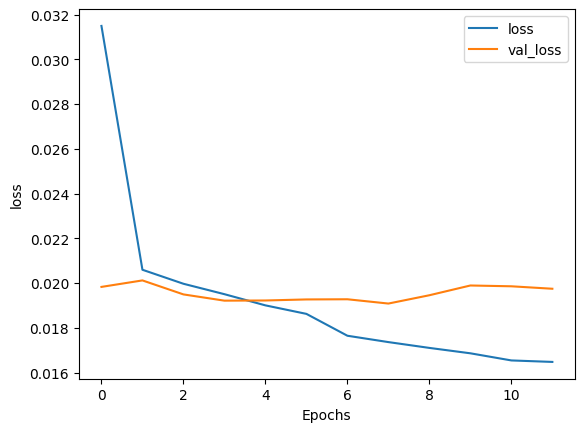

In [24]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "binary_accuracy")
plot_graphs(history, "loss")

In [25]:
predicted_probabilities = model.predict(testing_padded)

58/58 [==============================] - 3s 27ms/step


In [26]:
for i, text in enumerate(test_sentences[:5]):
    print(f"Abstract: {text}")
    print(f"Label(s): {invert_multi_hot(test_labels[i])}")
    predicted_proba = [proba for proba in predicted_probabilities[i]]
    top_positons = sorted(range(len(predicted_proba)), key=lambda i: predicted_proba[i])[-3:]
    print(f"Top 3 Positions: {top_positons}")
    top_3_labels = [
        x
        for _, x in sorted(
            zip(predicted_probabilities[i], lookup.get_vocabulary()),
            key=lambda pair: pair[0],
            reverse=True,
        )
    ][:3]
    print(f"Predicted Label(s): ({', '.join([label for label in top_3_labels])})")
    print(" ")

Abstract: imagine patient critical condition  measured forecast detrimental events  especially budget constraints answer question deep reinforcement learning rl jointly minimizes measurement cost maximizes predictive gain  scheduling strategically  timed measurements  learn policy dynamically dependent patients health history  scale framework exponentially large action space  distribute reward sequential setting makes learning easier  simulation  policy outperforms heuristic  based scheduling higher predictive gain lower cost  real  world icu mortality prediction task mimic3  policies reduce total number measurements 31 improve predictive gain factor 3 compared physicians  off  policy policy evaluation  


IndexError: index 2 is out of bounds for axis 0 with size 1

In [ ]:
# Save model
export_dir = '../../saved_model/recommender/arxiv/v1/modeltfjs/'
#export_dir = '../../saved_model/recommender/arxiv/v1/modeltflite/'
model.save(export_dir)